In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
files = ['Consumable', 'Non-Consumable']
address = 'D:/VIT/Meat-Quality-Assessment-and-Classification/Dataset/Chicken/'

In [5]:
data = {}
for f in files:
    data[f]=[]
for col in files:
    os.chdir(address+col)
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpg'):
            data[col].append(i)

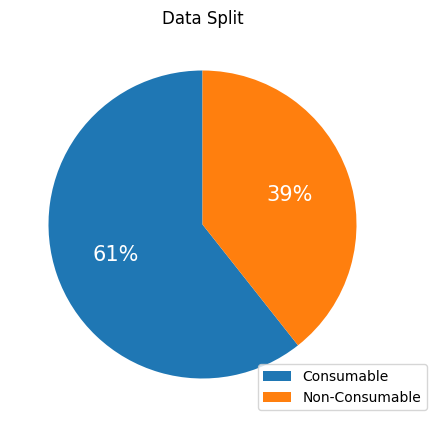

In [6]:
sizes = [len(data['Consumable']), len(data['Non-Consumable'])]
plt.figure(figsize=(10,5), dpi=100)
plt.pie(x=sizes,autopct='%1.0f%%',shadow=False, textprops={'color':"w","fontsize":15}, startangle=90)
plt.legend(files,bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

In [7]:
width = 100
height = 100

In [8]:
start = time.time()
image_data = []
image_target = []
for title in files:
    os.chdir(address+title)
    counter = 0
    for i in data[title]:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_data.append(cv2.resize(img,(width, height)))
        image_target.append(title)
        counter += 1
    clear_output(wait=True)
calculate_time = time.time() - start    
print("Calculate Time",round(calculate_time,5))

Calculate Time 34.55718


In [9]:
image_data = np.array(image_data)
size = image_data.shape[0]
image_data.shape

(310, 100, 100, 3)

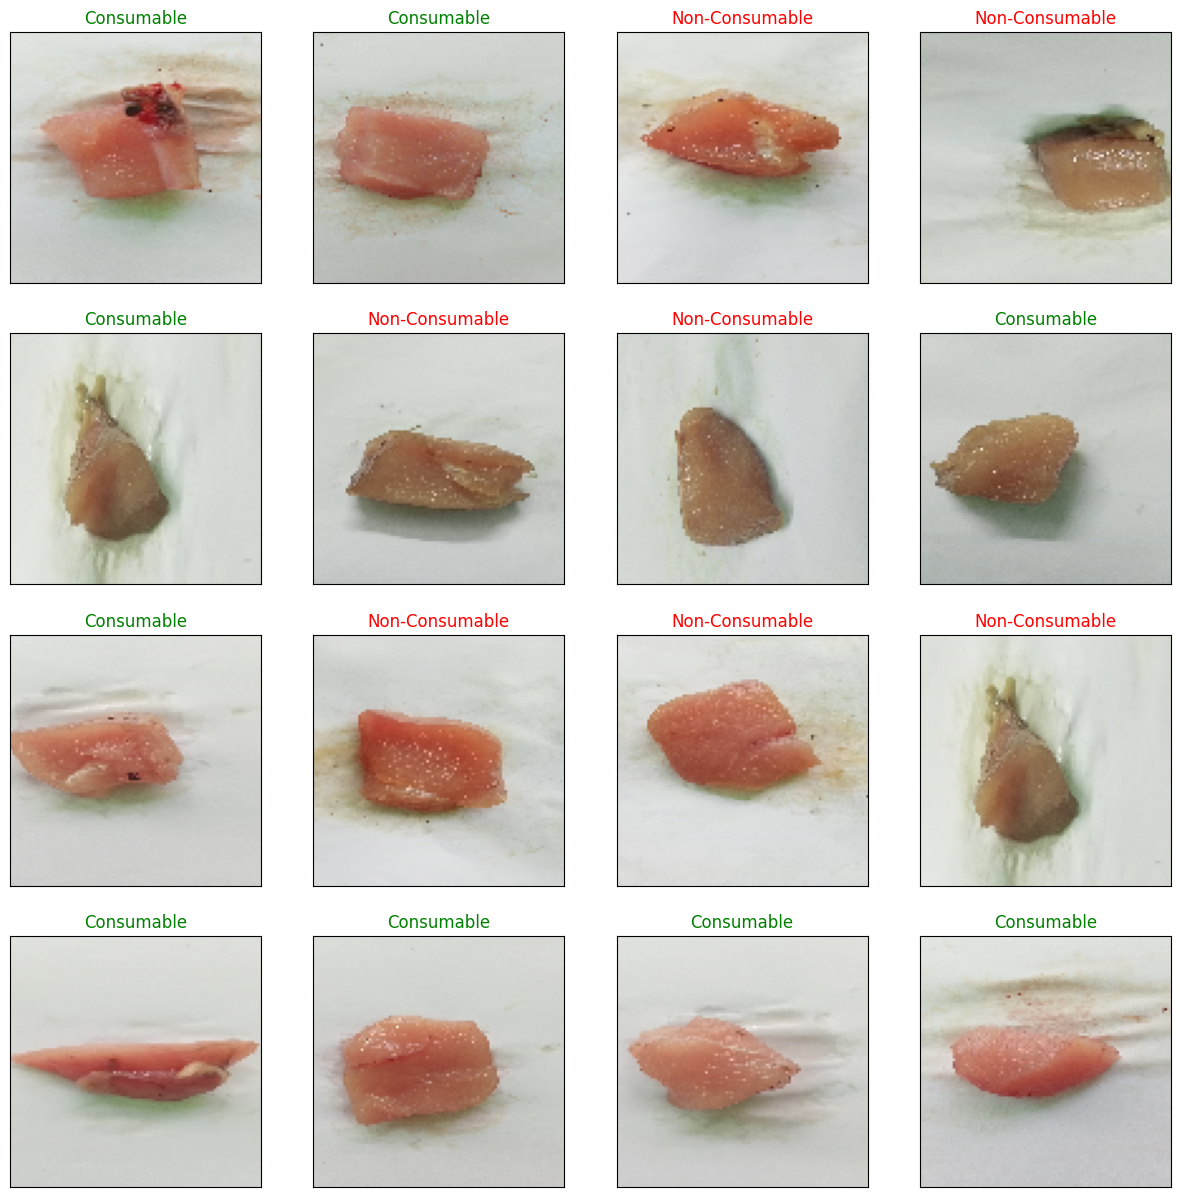

In [10]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if image_target[fig]=='Consumable':
        c='green'
    else:
        c='red'
    plt.title(image_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [11]:
labels = LabelEncoder()
labels.fit(image_target)

LabelEncoder()

In [12]:
X = image_data / 255.0
y = labels.transform(image_target)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=123)

In [13]:
def resnet_model(input_shape=(width,height,3)):
    resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    x = layers.Flatten()(resnet.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=resnet.input, outputs=predictions)
    for layer in resnet.layers:
        layer.trainable = False
    return model
model = resnet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 974ms/step - accuracy: 0.4819 - loss: 2.1867 - val_accuracy: 0.3978 - val_loss: 0.8399
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 515ms/step - accuracy: 0.4706 - loss: 0.7596 - val_accuracy: 0.6022 - val_loss: 0.7112
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 596ms/step - accuracy: 0.4822 - loss: 0.7173 - val_accuracy: 0.6022 - val_loss: 0.6803
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 576ms/step - accuracy: 0.6188 - loss: 0.6633 - val_accuracy: 0.4194 - val_loss: 0.6796
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 558ms/step - accuracy: 0.4895 - loss: 0.6718 - val_accuracy: 0.6022 - val_loss: 0.6419
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 559ms/step - accuracy: 0.6516 - loss: 0.6336 - val_accuracy: 0.3978 - val_loss: 0.6946
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 574ms/step - accuracy: 0.4697 - loss: 0.6865 - val_accuracy: 0.6129 - val_loss: 0.6280
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 553ms/step - accuracy: 0.6442 - loss: 0.6304 - val_accuracy: 0.6559 - val_loss

3/3 - 1s - 345ms/step - accuracy: 0.6022 - loss: 0.7404


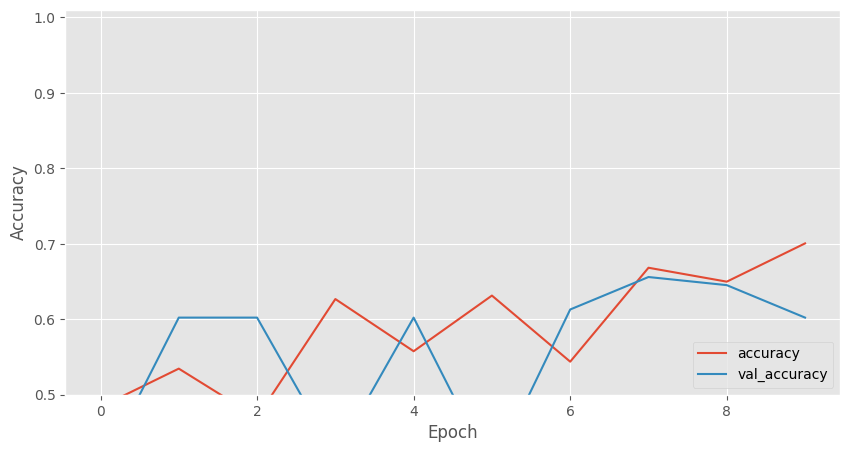

In [14]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.01])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [15]:
result=model.evaluate(test_images, test_labels)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - accuracy: 0.6136 - loss: 0.7199


In [16]:
for i in range(len(model.metrics_names)):
    print(model.metrics_names[i],":",result[i])

loss : 0.7403799295425415
compile_metrics : 0.602150559425354


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step  


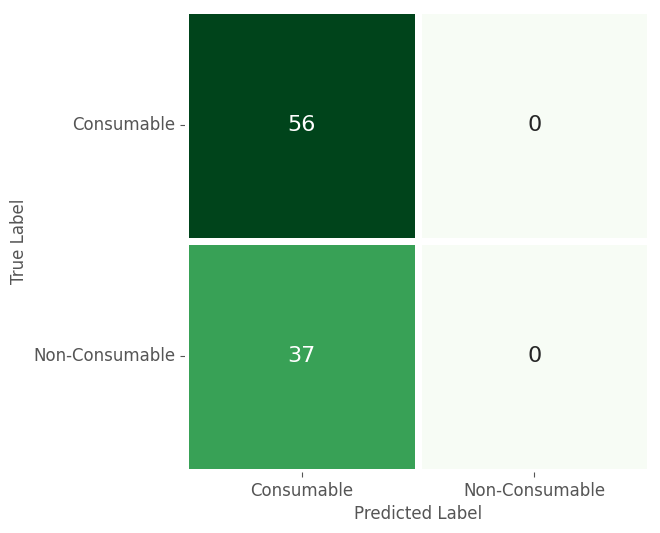

In [17]:
y_pred = model.predict(test_images)
def toClass(pred):
    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index
    return class_
cm = confusion_matrix(test_labels,toClass(y_pred))
df1 = pd.DataFrame(columns=["Consumable","Non-Consumable"], index= ["Consumable","Non-Consumable"], data= cm )
f,ax = plt.subplots(figsize=(6,6))
sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.show()

In [20]:
files = ['Consumable', 'Non-Consumable']
address = 'D:/VIT/Meat-Quality-Assessment-and-Classification/Dataset/Chicken/'

In [21]:
data = {}
for f in files:
    data[f]=[]
for col in files:
    os.chdir(address+col)
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpg'):
            data[col].append(i)

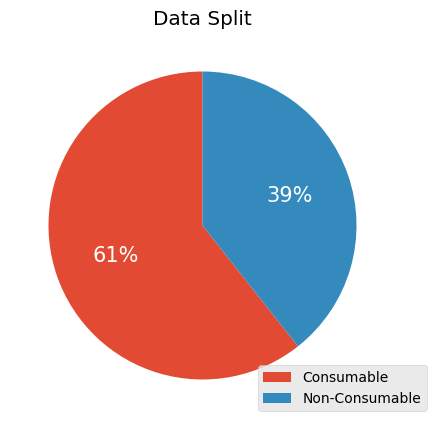

In [22]:
sizes = [len(data['Consumable']), len(data['Non-Consumable'])]
plt.figure(figsize=(10,5), dpi=100)
plt.pie(x=sizes,autopct='%1.0f%%',shadow=False, textprops={'color':"w","fontsize":15}, startangle=90)
plt.legend(files,bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

In [23]:
width = 100
height = 100

In [24]:
start = time.time()
image_data = []
image_target = []
for title in files:
    os.chdir(address+title)
    counter = 0
    for i in data[title]:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        image_data.append(cv2.resize(img,(width, height)))
        image_target.append(title)
        counter += 1
    clear_output(wait=True)
calculate_time = time.time() - start    
print("Calculate Time",round(calculate_time,5))

Calculate Time 36.10806


In [25]:
image_data = np.array(image_data)
size = image_data.shape[0]
image_data.shape

(310, 100, 100, 3)

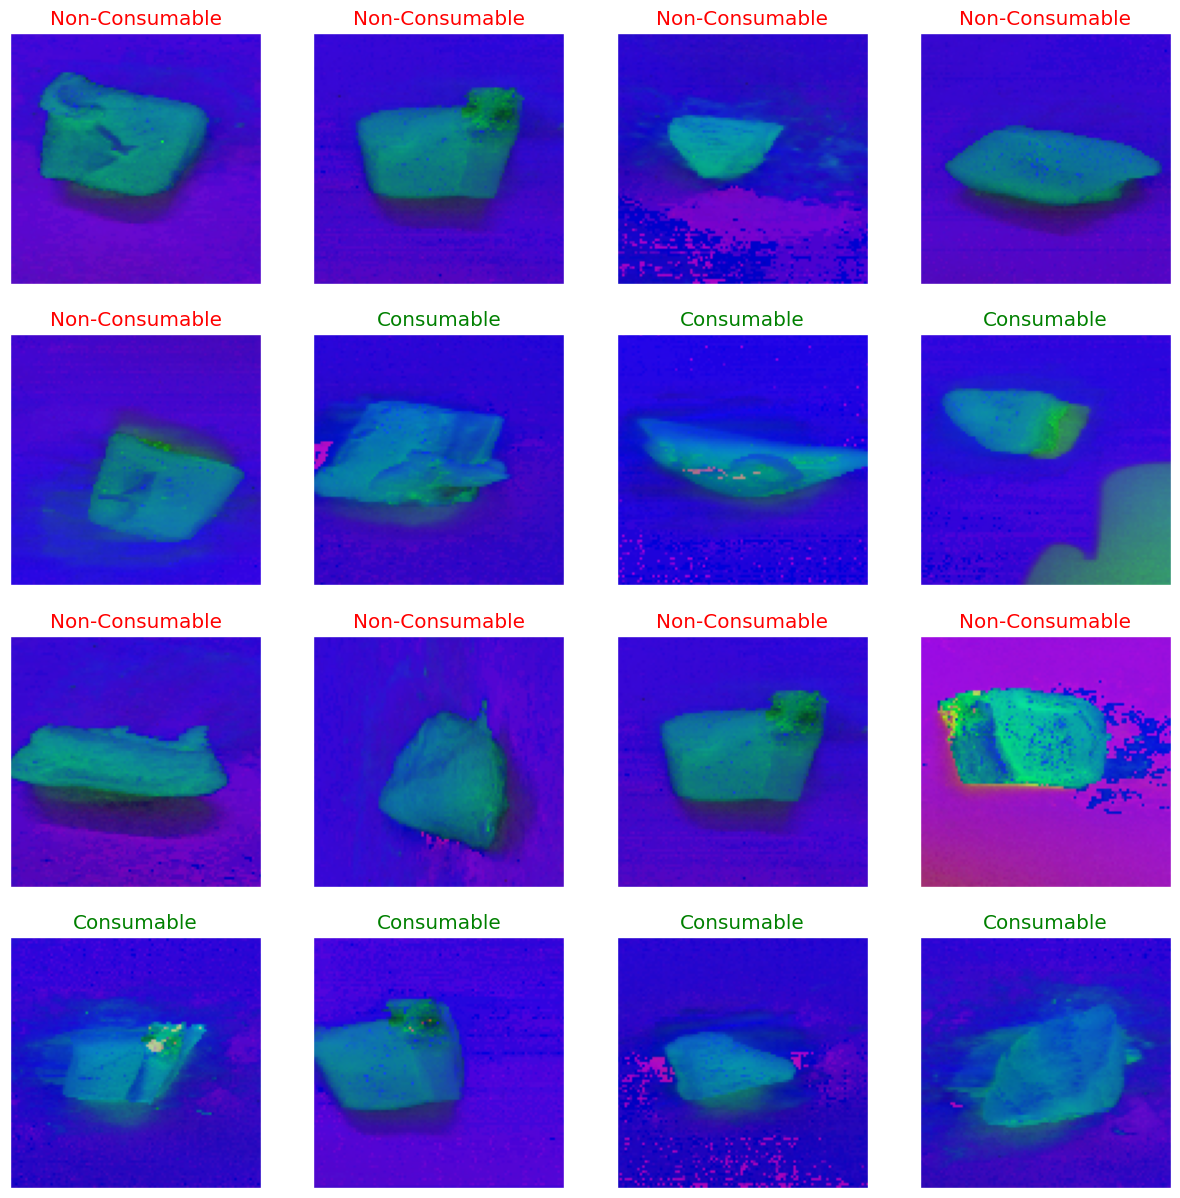

In [26]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if image_target[fig]=='Consumable':
        c='green'
    else:
        c='red'
    plt.title(image_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [27]:
labels = LabelEncoder()
labels.fit(image_target)

LabelEncoder()

In [28]:
X = image_data / 360.0
y = labels.transform(image_target)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=123)

In [29]:
def resnet_model(input_shape=(width,height,3)):
    resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    x = layers.Flatten()(resnet.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=resnet.input, outputs=predictions)
    for layer in resnet.layers:
        layer.trainable = False
    return model
model = resnet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.4260 - loss: 5.6169 - val_accuracy: 0.8065 - val_loss: 0.4005
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 754ms/step - accuracy: 0.7982 - loss: 0.4530 - val_accuracy: 0.7527 - val_loss: 0.6165
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 755ms/step - accuracy: 0.8551 - loss: 0.3859 - val_accuracy: 0.8710 - val_loss: 0.3050
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 762ms/step - accuracy: 0.9571 - loss: 0.1511 - val_accuracy: 0.8710 - val_loss: 0.3336
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 764ms/step - accuracy: 0.9331 - loss: 0.1314 - val_accuracy: 0.8925 - val_loss: 0.4192
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 754ms/step - accuracy: 0.9390 - loss: 0.1067 - val_accuracy: 0.8817 - val_loss: 0.3832
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 753ms/step - accuracy: 0.9609 - loss: 0.0796 - val_accuracy: 0.8495 - val_loss: 0.4147
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 773ms/step - accuracy: 0.9596 - loss: 0.0991 - val_accuracy: 0.8602 - val_loss: 0

3/3 - 2s - 548ms/step - accuracy: 0.8495 - loss: 0.5766


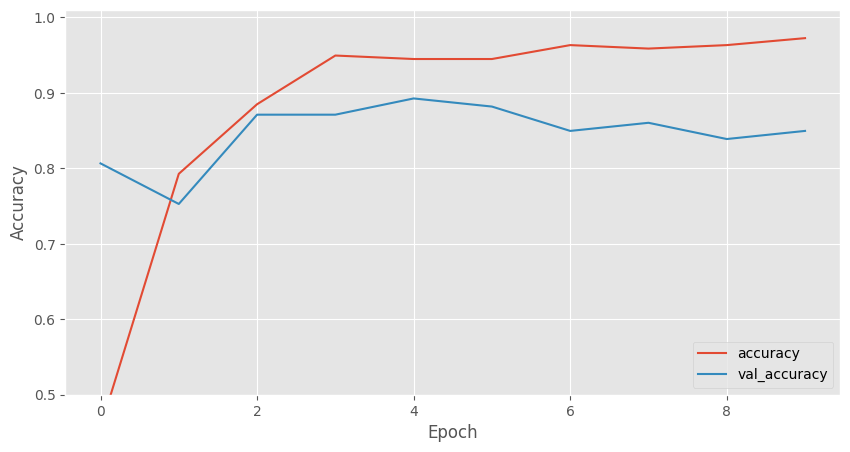

In [30]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.01])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [31]:
result=model.evaluate(test_images, test_labels)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 508ms/step - accuracy: 0.8349 - loss: 0.5827


In [32]:
for i in range(len(model.metrics_names)):
    print(model.metrics_names[i],":",result[i])

loss : 0.5765849351882935
compile_metrics : 0.8494623899459839


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step 


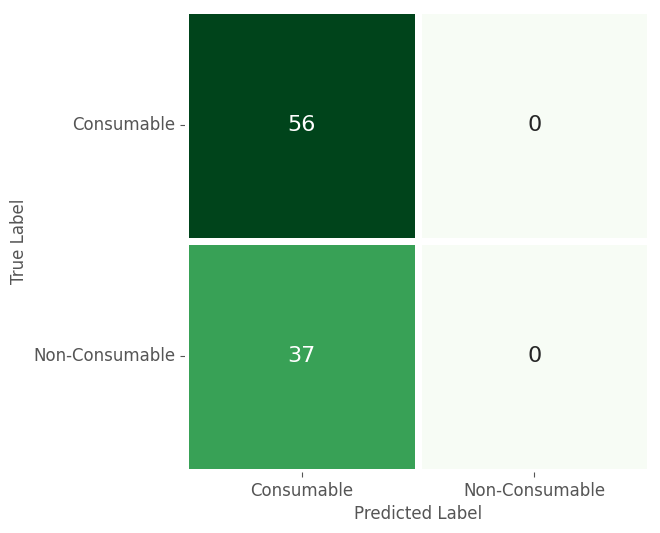

In [33]:
y_pred = model.predict(test_images)
def toClass(pred):
    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index
    return class_
cm = confusion_matrix(test_labels,toClass(y_pred))
df1 = pd.DataFrame(columns=["Consumable","Non-Consumable"], index= ["Consumable","Non-Consumable"], data= cm )
f,ax = plt.subplots(figsize=(6,6))
sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.show()